# DQN 

In [1]:
import random
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as fun
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import gymnasium as gym

In [2]:
env = gym.make("LunarLander-v3")
num_actions = 4 
state, info = env.reset()
num_observations = len(state) 


# CLASES

In [3]:
#memoria de experiencia
class Memory:
    def __init__(self, capacity=10000):
        self.memory = deque(maxlen=capacity)  # Almacena hasta 'capacity' transiciones
        self.batch_size = 64  # Tamaño del lote para el entrenamiento

    def cache(self, *args):
        self.memory.append(transitiones(*args))  # Guarda una transición (estado, acción, nuevo estado, recompensa)

    def recall(self):
        return random.sample(self.memory, self.batch_size)  # Obtiene un lote aleatorio de experiencias

    def __len__(self):
        return len(self.memory)


In [4]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.recall()

    batch = transitiones(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [5]:
# Se varía el uso de elegir acciones aleatorias o la de mayor recompensa, (decisión tomada en función de los mejores resultados neuroevolución)
def act(state):
    global steps
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps / EPS_DECAY)
    steps += 1
    if sample > eps_threshold:
        with torch.no_grad():
            action = policy_net(state).max(1)[1].view(1, 1) #explotacion
    else:
        action = torch.tensor([[env.action_space.sample()]], dtype=torch.long) #exploracion
    
    #print(f"Acción tomada: {action.item()}")  
    return action

In [6]:
def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    

    if durations_t.ndimension() == 1:
        max_rewards = durations_t  
    else:
        max_rewards = durations_t.max(1)[0]  
    
    if show_result:
        plt.title('Max Reward per Episode')
    else:
        plt.clf()
        plt.title('Training...')
    
    plt.xlabel('Episode')
    plt.ylabel('Max Reward')
    plt.plot(range(len(max_rewards)), max_rewards.numpy(),  color='red')
    
    plt.pause(0.001)  
    plt.show()

# Prueba 1
- Red Neuronal Sencilla (2 capas)
- Tamaño de Batch 64 y 128
- Función de Pérdida con Regularización
- Política Épsilon Greedy

In [20]:
# Optimizar modelo
#Calcular valores q y comparar con valores actuales para actualizar red (eq bellman 'adaptada', ver diapositivas)

transitiones = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class DQN(nn.Module):
    def __init__(self, num_observations, num_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(num_observations, 64)
        self.layer2 = nn.Linear(64, num_actions)  

    def forward(self, x):
        x = fun.relu(self.layer1(x))
        return self.layer2(x) 



## Batch 64

In [21]:
# HYPERPARÁMETROS
#(se controla la exploración/explotación, la tasa de aprendizaje y la actualización del target network)
BATCH_SIZE = 64
GAMMA = 0.99  # Factor de descuento para valorar recompensas futuras
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000  # Decaimiento de epsilon en la exploración
TAU = 0.001  # Parámetro para actualización suave de la red objetivo
LR = 1e-4  # Tasa de aprendizaje

# REDES
policy_net = DQN(num_observations, num_actions) #Red neuronal principal que se entrena
target_net = DQN(num_observations, num_actions) #Red auxiliar que ayuda a estabilizar el entrenamiento (actualizada con TAU).
target_net.load_state_dict(policy_net.state_dict()) # senicializa target_net con los mismos pesos de policy_net
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = Memory()


#ENTRENAMIENTO
steps = 0
episode_durations = []

EPOCHS = 100
for i_episode in range(EPOCHS):
    reward_total = 0
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

    for t in count():
        action = act(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())

        reward_total += reward
        reward = torch.tensor([reward])
        done = terminated or truncated

        if terminated:
            print(f"Episodio {i_episode} acabado con recompensa total:", reward_total)
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32).unsqueeze(0)

        # Almacenar transición en memoria
        memory.cache(state, action, next_state, reward)

        # Actualizar estado
        state = next_state

        # Optimizar modelo en este estado
        optimize_model()

        # Actualizar target network
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * TAU + target_net_state_dict[key] * (1 - TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(reward_total)
            break


Episodio 0 acabado con recompensa total: -328.83053399562004
Episodio 1 acabado con recompensa total: -148.65386060738717
Episodio 2 acabado con recompensa total: 29.203327265547244
Episodio 3 acabado con recompensa total: -203.6342953594314
Episodio 4 acabado con recompensa total: -331.8053613113045
Episodio 5 acabado con recompensa total: -334.5611165556369
Episodio 6 acabado con recompensa total: -314.24326625517415
Episodio 7 acabado con recompensa total: -331.13154969384016
Episodio 8 acabado con recompensa total: -322.035180923702
Episodio 9 acabado con recompensa total: -498.7953726897156
Episodio 10 acabado con recompensa total: -433.917476161581
Episodio 11 acabado con recompensa total: -113.5003073905286
Episodio 12 acabado con recompensa total: -282.31728122486675
Episodio 13 acabado con recompensa total: -141.40099464494259
Episodio 14 acabado con recompensa total: -161.09617580326488
Episodio 15 acabado con recompensa total: -179.6846023938799
Episodio 16 acabado con recom

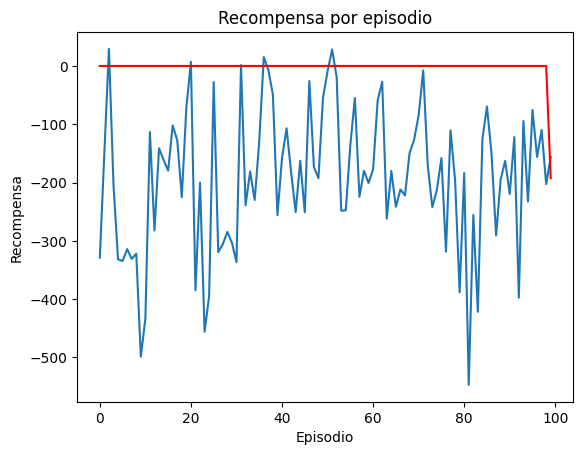

In [22]:
def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Recompensa por episodio')
    else:
        plt.clf()
        plt.title('Entreno...')
    plt.xlabel('Episodio')
    plt.ylabel('Recompensa')
    plt.plot(durations_t.numpy())
    
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy(), color='red')

    plt.pause(0.001)  
    plt.show()

plot_durations(show_result=True)
plt.ioff()
plt.show()

## Batch 128

In [7]:
transitiones = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class DQN(nn.Module):
    def __init__(self, num_observations, num_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(num_observations, 128)
        self.layer2 = nn.Linear(128, num_actions)  

    def forward(self, x):
        x = fun.relu(self.layer1(x))
        return self.layer2(x) 


class Memory:
    def __init__(self, capacity=10000):
        self.memory = deque(maxlen=capacity)  # Almacena hasta 'capacity' transiciones
        self.batch_size = 128  # Tamaño del lote para el entrenamiento

    def cache(self, *args):
        self.memory.append(transitiones(*args))  # Guarda una transición (estado, acción, nuevo estado, recompensa)

    def recall(self):
        return random.sample(self.memory, self.batch_size)  # Obtiene un lote aleatorio de experiencias

    def __len__(self):
        return len(self.memory)



In [9]:
# HYPERPARÁMETROS
BATCH_SIZE = 128
GAMMA = 0.99  
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000  
TAU = 0.001  
LR = 1e-4 

# REDES
policy_net = DQN(num_observations, num_actions) 
target_net = DQN(num_observations, num_actions) 
target_net.load_state_dict(policy_net.state_dict()) 
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = Memory()



#ENTRENAMIENTO
steps = 0
episode_durations = []

EPOCHS = 200
for i_episode in range(EPOCHS):
    reward_total = 0
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

    for t in count():
        action = act(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())

        reward_total += reward
        reward = torch.tensor([reward])
        done = terminated or truncated

        if terminated:
            print(f"Episodio {i_episode} acabado con recompensa total:", reward_total)
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32).unsqueeze(0)

        # Almacenar transición en memoria
        memory.cache(state, action, next_state, reward)

        # Actualizar estado
        state = next_state

        # Optimizar modelo en este estado
        optimize_model()

        # Actualizar target network
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * TAU + target_net_state_dict[key] * (1 - TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(reward_total)
            break


Episodio 0 acabado con recompensa total: -167.20253295257987
Episodio 1 acabado con recompensa total: -301.34103470032073
Episodio 2 acabado con recompensa total: -492.6146955714096
Episodio 3 acabado con recompensa total: -372.07735919532274
Episodio 4 acabado con recompensa total: -235.5988295429674
Episodio 5 acabado con recompensa total: -215.00805172052185
Episodio 6 acabado con recompensa total: -162.01683647738338
Episodio 7 acabado con recompensa total: -224.4170921382721
Episodio 8 acabado con recompensa total: -249.75901837051236
Episodio 9 acabado con recompensa total: -140.98134280854788
Episodio 10 acabado con recompensa total: -49.89329767267
Episodio 11 acabado con recompensa total: -109.93875255625301
Episodio 12 acabado con recompensa total: -34.99512168200408
Episodio 13 acabado con recompensa total: -227.3178977909717
Episodio 14 acabado con recompensa total: -234.25447501280905
Episodio 15 acabado con recompensa total: -220.12175109363625
Episodio 16 acabado con rec

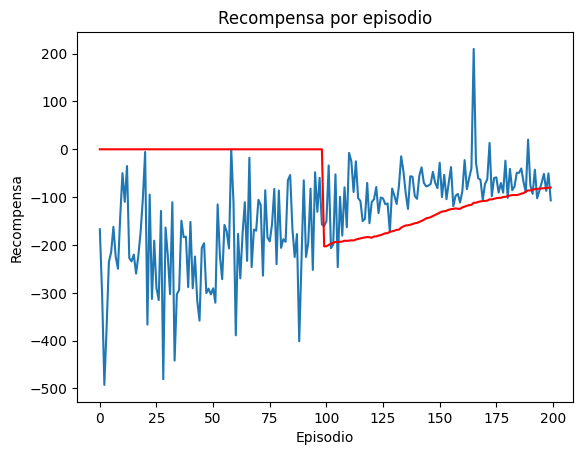

In [12]:
plot_durations(show_result=True)
plt.ioff()
plt.show()

# Prueba 2
- Red Neuronal Sencilla Más Grande 
- Tamaño de Batch 128
- Resto de Parámetros Igual

In [8]:
transitiones = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class DQN(nn.Module):
    def __init__(self, num_observations, num_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(num_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, 128)
        self.layer4 = nn.Linear(128, num_actions)  

    def forward(self, x):
        x = fun.relu(self.layer1(x))
        x = fun.relu(self.layer2(x))
        x = fun.relu(self.layer3(x))
        return self.layer4(x)  

In [26]:
# HYPERPARÁMETROS
BATCH_SIZE = 128
GAMMA = 0.99  
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000  
TAU = 0.001  
LR = 1e-4 

# REDES
policy_net = DQN(num_observations, num_actions) 
target_net = DQN(num_observations, num_actions) 
target_net.load_state_dict(policy_net.state_dict()) 
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = Memory()


#ENTRENAMIENTO
steps = 0
episode_durations = []

EPOCHS = 200
for i_episode in range(EPOCHS):
    reward_total = 0
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

    for t in count():
        action = act(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())

        reward_total += reward
        reward = torch.tensor([reward])
        done = terminated or truncated

        if terminated:
            print(f"Episodio {i_episode} acabado con recompensa total:", reward_total)
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32).unsqueeze(0)

        # Almacenar transición en memoria
        memory.cache(state, action, next_state, reward)

        # Actualizar estado
        state = next_state

        # Optimizar modelo en este estado
        optimize_model()

        # Actualizar target network
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * TAU + target_net_state_dict[key] * (1 - TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(reward_total)
            break


Episodio 0 acabado con recompensa total: -119.10528733326186
Episodio 1 acabado con recompensa total: -202.41582877411133
Episodio 2 acabado con recompensa total: -118.8070432353297
Episodio 3 acabado con recompensa total: -293.51998912319385
Episodio 4 acabado con recompensa total: -312.7724764651929
Episodio 5 acabado con recompensa total: -380.72080917632826
Episodio 6 acabado con recompensa total: -719.8541689810454
Episodio 7 acabado con recompensa total: -595.7750419880483
Episodio 8 acabado con recompensa total: -351.41914954588583
Episodio 9 acabado con recompensa total: -490.3711766205086
Episodio 10 acabado con recompensa total: -528.5945612885578
Episodio 11 acabado con recompensa total: -126.29494273566824
Episodio 12 acabado con recompensa total: -170.47363665252948
Episodio 13 acabado con recompensa total: -104.34689428007289
Episodio 14 acabado con recompensa total: -269.5566099456123
Episodio 15 acabado con recompensa total: -329.3340913392328
Episodio 16 acabado con re

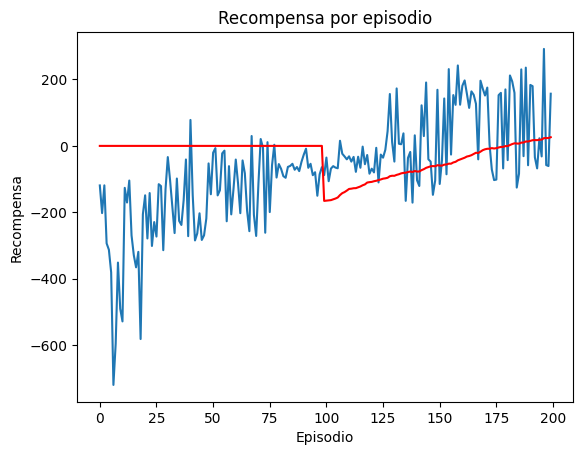

In [27]:
plot_durations(show_result=True)
plt.ioff()
plt.show()

# Prueba 3
- Red Neuronal (Leaky Relu)
- Tamaño de Batch 128


In [9]:
transitiones = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class DQN(nn.Module):
    def __init__(self, num_observations, num_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(num_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, 128)
        self.layer4 = nn.Linear(128, num_actions)  

    def forward(self, x):
        x = fun.leaky_relu(self.layer1(x))
        x = fun.leaky_relu(self.layer2(x))
        x = fun.leaky_relu(self.layer3(x))
        return self.layer4(x)  
        #devuelve predicciones de valores Q para cada acción posible

In [10]:
#PARÁMETROS
BATCH_SIZE = 128
GAMMA = 0.99  
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000  
TAU = 0.001  
LR = 1e-4 


#REDES
policy_net = DQN(num_observations, num_actions)
target_net = DQN(num_observations, num_actions) 
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = Memory()



#ENTRENAR
steps = 0
episode_durations = []

EPOCHS = 200
for i_episode in range(EPOCHS):
    reward_total = 0
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

    for t in count():
        action = act(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())

        reward_total += reward
        reward = torch.tensor([reward])
        done = terminated or truncated

        if terminated:
            print(f"Episodio {i_episode} acabado con recompensa total:", reward_total)
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32).unsqueeze(0)
        memory.cache(state, action, next_state, reward)
        state = next_state
        optimize_model()
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * TAU + target_net_state_dict[key] * (1 - TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(reward_total)
            break


Episodio 0 acabado con recompensa total: -193.7939290814789
Episodio 1 acabado con recompensa total: 11.818019740191119
Episodio 2 acabado con recompensa total: -12.46136770780798
Episodio 3 acabado con recompensa total: -234.4512922037984
Episodio 4 acabado con recompensa total: -225.52310460850495
Episodio 5 acabado con recompensa total: -223.07448603822775
Episodio 6 acabado con recompensa total: -114.51117043309041
Episodio 7 acabado con recompensa total: -134.1703024200453
Episodio 9 acabado con recompensa total: -114.89249834204392
Episodio 11 acabado con recompensa total: 167.3179358181343
Episodio 12 acabado con recompensa total: 228.40284072776495
Episodio 13 acabado con recompensa total: -242.56480902403325
Episodio 14 acabado con recompensa total: -229.39167731582793
Episodio 15 acabado con recompensa total: 216.5425773533246
Episodio 16 acabado con recompensa total: 7.256698488691967
Episodio 17 acabado con recompensa total: -264.66723149019265
Episodio 18 acabado con recom

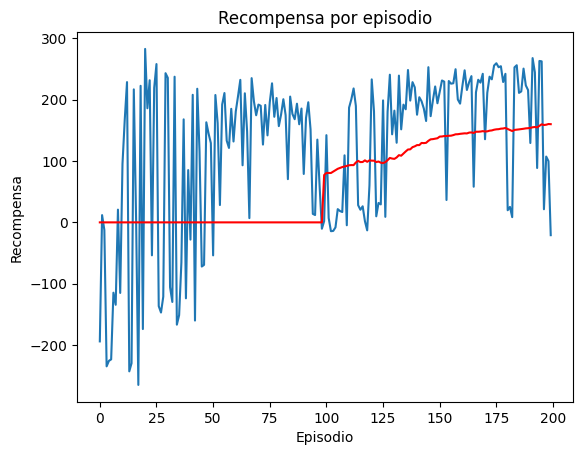

In [12]:
def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Recompensa por episodio')
    else:
        plt.clf()
        plt.title('Entreno...')
    plt.xlabel('Episodio')
    plt.ylabel('Recompensa')
    plt.plot(durations_t.numpy())
    
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy(), color='red')

    plt.pause(0.001)  
    plt.show()
plot_durations(show_result=True)
plt.ioff()
plt.show()